<a href="https://colab.research.google.com/github/jrebull/AnaliticaPrescriptiva/blob/main/MIAAD_PROGRA_Caso4_Rendimiento_Energetico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimización de Rendimiento Energético - Problema de Calderas

**Maestría en Inteligencia Artificial y Analítica de Datos (MIAAD)**  
**Universidad Autónoma de Ciudad Juárez**

**Autor:** Javier Augusto Rebull Saucedo  
**Matrícula:** al263483  
**Profesor:** Dr. Gilberto Rivera Zarate

---

## Problema
Optimizar la distribución de carga entre dos calderas industriales (A y B) para minimizar el consumo de combustible mientras se satisface una demanda de 60 ton/h de vapor.

**Características:**
- Eficiencias no lineales (cuadráticas)
- Restricciones de capacidad
- Eficiencia mínima del 15%

## Celda 1: Importación de Librerías  e Instalación de Librerías

In [1]:
# ============================================================
# INSTALACIÓN DE PYOMO E IPOPT PARA GOOGLE COLAB
# ============================================================
# Este script intenta múltiples métodos de instalación para
# asegurar que IPOPT esté disponible en el entorno.
# ============================================================

import sys
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("🔧 Iniciando instalación de Pyomo e IPOPT...\n")

# ------------------------------------------------------------
# MÉTODO 1: Instalar desde repositorios apt (más rápido)
# ------------------------------------------------------------
print("📦 Método 1: Instalando desde repositorios apt...")
!apt-get update -qq > /dev/null 2>&1
!apt-get install -y -qq coinor-libipopt1v5 coinor-libipopt-dev coinor-bonmin > /dev/null 2>&1

# Instalar Pyomo
print("🐍 Instalando Pyomo...")
!pip install -q pyomo

# ------------------------------------------------------------
# VERIFICAR SI IPOPT ESTÁ DISPONIBLE
# ------------------------------------------------------------
print("\n🔍 Verificando instalación de IPOPT...")
ipopt_found = False

# Buscar en PATH
result_which = subprocess.run(['which', 'ipopt'], capture_output=True, text=True)
if result_which.returncode == 0 and result_which.stdout.strip():
    print(f"✅ IPOPT encontrado en PATH: {result_which.stdout.strip()}")
    ipopt_found = True
else:
    # Buscar en todo el sistema
    print("🔍 IPOPT no encontrado en PATH, buscando en el sistema...")
    result_find = subprocess.run(['find', '/usr', '-name', 'ipopt', '-type', 'f', '2>/dev/null'],
                                 capture_output=True, text=True, shell=False)

    if result_find.stdout:
        ipopt_path = result_find.stdout.strip().split('\n')[0]
        print(f"✅ IPOPT encontrado en: {ipopt_path}")
        # Agregar al PATH
        os.environ['PATH'] = os.path.dirname(ipopt_path) + ':' + os.environ['PATH']
        ipopt_found = True

# ------------------------------------------------------------
# MÉTODO 2: Instalar con micromamba (si método 1 falló)
# ------------------------------------------------------------
if not ipopt_found:
    print("\n⚠️  Método apt falló. Intentando con micromamba...")

    # Quitar repos problemáticos
    !sed -i '/r2u.stat.illinois.edu/ s/^/#/' /etc/apt/sources.list 2>/dev/null || true
    !sed -i '/r2u.stat.illinois.edu/ s/^/#/' /etc/apt/sources.list.d/* 2>/dev/null || true

    # Instalar micromamba
    print("📦 Descargando micromamba...")
    !wget -qO- https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba > /dev/null 2>&1

    # Crear entorno con ipopt
    print("🔧 Creando entorno conda con IPOPT...")
    !./bin/micromamba create -y -p /usr/local/ipopt-env -c conda-forge ipopt pyomo > /dev/null 2>&1

    # Exponer el ejecutable
    !ln -sf /usr/local/ipopt-env/bin/ipopt /usr/bin/ipopt 2>/dev/null || true

    # Verificar nuevamente
    result_final = subprocess.run(['which', 'ipopt'], capture_output=True, text=True)
    if result_final.returncode == 0:
        print(f"✅ IPOPT instalado exitosamente: {result_final.stdout.strip()}")
        ipopt_found = True

# ------------------------------------------------------------
# VERIFICACIÓN FINAL Y PRUEBA CON PYOMO
# ------------------------------------------------------------
print("\n" + "="*60)
print("        VERIFICACIÓN FINAL DE INSTALACIÓN")
print("="*60)

# Verificar versión de IPOPT
if ipopt_found:
    print("\n📋 Información de IPOPT:")
    !ipopt -v 2>/dev/null || echo "   Instalado pero versión no disponible"

# Probar con Pyomo
print("\n🧪 Probando disponibilidad en Pyomo...")
try:
    import pyomo.environ as pyo

    # Probar IPOPT
    solver_ipopt = pyo.SolverFactory('ipopt')
    if solver_ipopt.available():
        print("   ✅ IPOPT disponible en Pyomo")
    else:
        print("   ⚠️  IPOPT no disponible en Pyomo (intentando alternativas)")

    # Verificar solvers alternativos
    solvers_disponibles = []
    for solver_name in ['ipopt', 'bonmin', 'couenne', 'baron']:
        try:
            solver = pyo.SolverFactory(solver_name)
            if solver.available():
                solvers_disponibles.append(solver_name)
        except:
            pass

    if solvers_disponibles:
        print(f"\n🎯 Solvers NLP disponibles: {', '.join(solvers_disponibles)}")
    else:
        print("\n❌ No se encontraron solvers NLP disponibles")
        print("💡 Sugerencia: El código usará fallback a métodos alternativos")

except Exception as e:
    print(f"   ❌ Error al verificar Pyomo: {e}")

import pyomo.environ as pyo
import numpy as np

print("\n" + "="*60)
print("✅ Instalación completada")
print("="*60)

🔧 Iniciando instalación de Pyomo e IPOPT...

📦 Método 1: Instalando desde repositorios apt...
🐍 Instalando Pyomo...

🔍 Verificando instalación de IPOPT...
✅ IPOPT encontrado en PATH: /usr/bin/ipopt

        VERIFICACIÓN FINAL DE INSTALACIÓN

📋 Información de IPOPT:
Ipopt 3.14.19 (Linux x86_64), ASL(20231111)


🧪 Probando disponibilidad en Pyomo...


Failed to set executable for solver asl. File with name=bonmin either does not exist or it is not executable. To skip this validation, call set_executable with validate=False.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pyomo/opt/base/solvers.py", line 175, in __call__
    opt = self._cls[_implicit_solvers[mode]](**kwds)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pyomo/solvers/plugins/solvers/ASL.py", line 46, in __init__
    SystemCallSolver.__init__(self, **kwds)
  File "/usr/local/lib/python3.12/dist-packages/pyomo/opt/solver/shellcmd.py", line 66, in __init__
    self.set_executable(name=executable, validate=validate)
  File "/usr/local/lib/python3.12/dist-packages/pyomo/opt/solver/shellcmd.py", line 115, in set_executable
    raise ValueError(
ValueError: Failed to set executable for solver asl. File with name=bonmin either does not exist or it is not executable. To skip this validatio

   ✅ IPOPT disponible en Pyomo

🎯 Solvers NLP disponibles: ipopt

✅ Instalación completada


## Celda 3: Definición de Parámetros

Parámetros físicos del sistema basados en el problema:

### Constantes Físicas
- **h (Calor específico):** 4,200 kJ/kg
- **PCI (Poder calorífico inferior):** 45,000 kJ/kg
- **Demanda total:** 60 ton/h

### Calderas
- **Caldera A:** 10-38.7 ton/h, η_A(x) = 0.9 - 0.0005x²
- **Caldera B:** 20-42.72 ton/h, η_B(y) = 0.88 - 0.0004y²

In [2]:
# Parámetros físicos
h = 4200  # kJ/kg - Calor específico
PCI = 45000  # kJ/kg - Poder calorífico inferior
DEMANDA = 60  # ton/h - Demanda total de vapor

# Límites de producción (ton/h)
X_MIN = 10
X_MAX = 38.7
Y_MIN = 20
Y_MAX = 42.72

# Eficiencia mínima permitida
ETA_MIN = 0.15

# Coeficientes de eficiencia
# Caldera A: ηA = 0.9 - 0.0005x²
ETA_A_0 = 0.9
ETA_A_1 = 0.0005

# Caldera B: ηB = 0.88 - 0.0004y²
ETA_B_0 = 0.88
ETA_B_1 = 0.0004

print(f"""
Parámetros del Sistema:
{'='*50}
Calor específico (h):     {h:,.0f} kJ/kg
Poder calorífico (PCI):   {PCI:,.0f} kJ/kg
Demanda de vapor:         {DEMANDA} ton/h

Límites Caldera A:        [{X_MIN}, {X_MAX}] ton/h
Límites Caldera B:        [{Y_MIN}, {Y_MAX}] ton/h
Eficiencia mínima:        {ETA_MIN*100}%
""")


Parámetros del Sistema:
Calor específico (h):     4,200 kJ/kg
Poder calorífico (PCI):   45,000 kJ/kg
Demanda de vapor:         60 ton/h

Límites Caldera A:        [10, 38.7] ton/h
Límites Caldera B:        [20, 42.72] ton/h
Eficiencia mínima:        15.0%



## Celda 4: Creación del Modelo de Optimización

Modelo de Programación No Lineal (NLP):

### Variables
- `x`: flujo de vapor de caldera A (ton/h)
- `y`: flujo de vapor de caldera B (ton/h)

### Función Objetivo
Minimizar: $(x \cdot h)/(\eta_A \cdot PCI) + (y \cdot h)/(\eta_B \cdot PCI)$

### Restricciones
1. $x + y = 60$ (demanda)
2. $10 \leq x \leq 38.7$
3. $20 \leq y \leq 42.72$
4. $\eta_A \geq 0.15$
5. $\eta_B \geq 0.15$

In [3]:
def crear_modelo():
    """
    Crea y retorna el modelo de optimización de Pyomo
    """
    model = pyo.ConcreteModel(name="Optimización_Rendimiento_Energético")

    # Variables de decisión
    model.x = pyo.Var(domain=pyo.NonNegativeReals,
                      bounds=(X_MIN, X_MAX),
                      doc="Flujo de vapor caldera A (ton/h)")

    model.y = pyo.Var(domain=pyo.NonNegativeReals,
                      bounds=(Y_MIN, Y_MAX),
                      doc="Flujo de vapor caldera B (ton/h)")

    # Función objetivo: Minimizar consumo de combustible
    def objetivo_rule(m):
        eta_A = ETA_A_0 - ETA_A_1 * m.x**2
        eta_B = ETA_B_0 - ETA_B_1 * m.y**2

        # Consumo de combustible (kg/h)
        consumo_A = (m.x * 1000 * h) / (eta_A * PCI)
        consumo_B = (m.y * 1000 * h) / (eta_B * PCI)

        return consumo_A + consumo_B

    model.objetivo = pyo.Objective(rule=objetivo_rule, sense=pyo.minimize)

    # Restricción: Satisfacer la demanda total
    def demanda_rule(m):
        return m.x + m.y == DEMANDA

    model.restriccion_demanda = pyo.Constraint(rule=demanda_rule)

    # Restricción: Eficiencia mínima caldera A
    def eficiencia_A_rule(m):
        eta_A = ETA_A_0 - ETA_A_1 * m.x**2
        return eta_A >= ETA_MIN

    model.restriccion_eta_A = pyo.Constraint(rule=eficiencia_A_rule)

    # Restricción: Eficiencia mínima caldera B
    def eficiencia_B_rule(m):
        eta_B = ETA_B_0 - ETA_B_1 * m.y**2
        return eta_B >= ETA_MIN

    model.restriccion_eta_B = pyo.Constraint(rule=eficiencia_B_rule)

    return model

# Crear el modelo
modelo = crear_modelo()

print("✓ Modelo de optimización creado exitosamente")
print(f"\nResumen del modelo:")
print(f"  Variables:      {modelo.nvariables()}")
print(f"  Restricciones:  {modelo.nconstraints()}")

✓ Modelo de optimización creado exitosamente

Resumen del modelo:
  Variables:      2
  Restricciones:  3


## Celda 5: Resolución con IPOPT

IPOPT (Interior Point OPTimizer) es un solver de código abierto para problemas de optimización no lineal a gran escala.

In [4]:
# Crear el solver
#solver = SolverFactory('ipopt')

solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 3000 # Ejemplo de configuración de una opción

# Configurar opciones del solver
solver.options['max_iter'] = 3000
solver.options['tol'] = 1e-6

print("Resolviendo el modelo con IPOPT...")
print("="*60)

# Resolver el modelo
resultado = solver.solve(modelo, tee=True)

print("="*60)
print("✓ Optimización completada")

Resolviendo el modelo con IPOPT...
Ipopt 3.14.19: max_iter=3000
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.8.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of e

## Celda 6: Extracción y Presentación de Resultados

In [5]:
# Verificar si se encontró una solución óptima
if (resultado.solver.status == pyo.SolverStatus.ok and
    resultado.solver.termination_condition == pyo.TerminationCondition.optimal):

    print("\n" + "="*60)
    print("SOLUCIÓN ÓPTIMA ENCONTRADA")
    print("="*60)

    # Extraer valores óptimos
    x_opt = pyo.value(modelo.x)
    y_opt = pyo.value(modelo.y)

    # Calcular eficiencias
    eta_A_opt = ETA_A_0 - ETA_A_1 * x_opt**2
    eta_B_opt = ETA_B_0 - ETA_B_1 * y_opt**2

    # Calcular consumo
    consumo_A_opt = (x_opt * 1000 * h) / (eta_A_opt * PCI)
    consumo_B_opt = (y_opt * 1000 * h) / (eta_B_opt * PCI)
    consumo_total_opt = consumo_A_opt + consumo_B_opt

    print(f"\n{'ASIGNACIÓN ÓPTIMA DE CARGA':^60}")
    print("-"*60)
    print(f"Caldera A: {x_opt:8.4f} ton/h  ({x_opt/DEMANDA*100:5.2f}% de la demanda)")
    print(f"Caldera B: {y_opt:8.4f} ton/h  ({y_opt/DEMANDA*100:5.2f}% de la demanda)")
    print(f"Total:     {x_opt + y_opt:8.4f} ton/h")

    print(f"\n{'EFICIENCIAS OPERATIVAS':^60}")
    print("-"*60)
    print(f"Eficiencia Caldera A: {eta_A_opt*100:6.2f}%")
    print(f"Eficiencia Caldera B: {eta_B_opt*100:6.2f}%")

    print(f"\n{'CONSUMO DE COMBUSTIBLE':^60}")
    print("-"*60)
    print(f"Consumo Caldera A: {consumo_A_opt:10,.2f} kg/h")
    print(f"Consumo Caldera B: {consumo_B_opt:10,.2f} kg/h")
    print(f"{'CONSUMO TOTAL:':<20} {consumo_total_opt:10,.2f} kg/h")
    print("="*60)

    # Guardar resultados
    resultados_opt = {
        'x_opt': x_opt,
        'y_opt': y_opt,
        'eta_A_opt': eta_A_opt,
        'eta_B_opt': eta_B_opt,
        'consumo_A_opt': consumo_A_opt,
        'consumo_B_opt': consumo_B_opt,
        'consumo_total_opt': consumo_total_opt
    }

else:
    print("\n⚠️  No se encontró una solución óptima")
    resultados_opt = None


SOLUCIÓN ÓPTIMA ENCONTRADA

                 ASIGNACIÓN ÓPTIMA DE CARGA                 
------------------------------------------------------------
Caldera A:  28.5822 ton/h  (47.64% de la demanda)
Caldera B:  31.4178 ton/h  (52.36% de la demanda)
Total:      60.0000 ton/h

                   EFICIENCIAS OPERATIVAS                   
------------------------------------------------------------
Eficiencia Caldera A:  49.15%
Eficiencia Caldera B:  48.52%

                   CONSUMO DE COMBUSTIBLE                   
------------------------------------------------------------
Consumo Caldera A:   5,427.30 kg/h
Consumo Caldera B:   6,043.93 kg/h
CONSUMO TOTAL:        11,471.23 kg/h


## Celda 7: Visualización - Eficiencia vs Carga

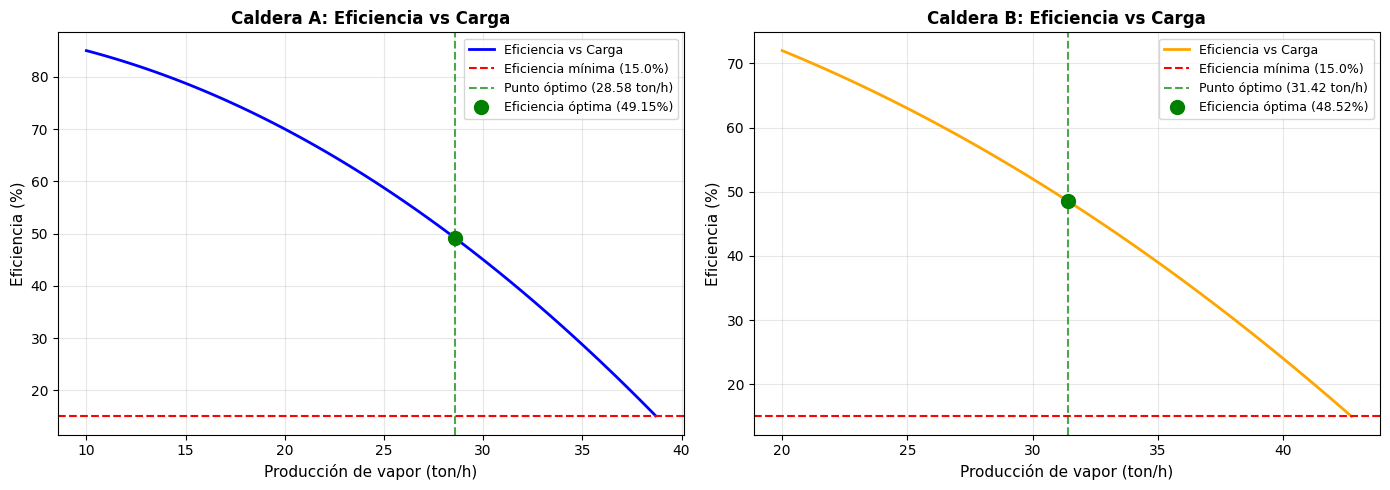

✓ Gráficas de eficiencia generadas


In [6]:
if resultados_opt is not None:
    # Crear rangos de producción
    x_range = np.linspace(X_MIN, X_MAX, 100)
    y_range = np.linspace(Y_MIN, Y_MAX, 100)

    # Calcular eficiencias
    eta_A_range = ETA_A_0 - ETA_A_1 * x_range**2
    eta_B_range = ETA_B_0 - ETA_B_1 * y_range**2

    # Crear figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfica 1: Eficiencia Caldera A
    ax1.plot(x_range, eta_A_range*100, 'b-', linewidth=2, label='Eficiencia vs Carga')
    ax1.axhline(y=ETA_MIN*100, color='r', linestyle='--', label=f'Eficiencia mínima ({ETA_MIN*100}%)')
    ax1.axvline(x=x_opt, color='g', linestyle='--', alpha=0.7, label=f'Punto óptimo ({x_opt:.2f} ton/h)')
    ax1.plot(x_opt, eta_A_opt*100, 'go', markersize=10, label=f'Eficiencia óptima ({eta_A_opt*100:.2f}%)')
    ax1.set_xlabel('Producción de vapor (ton/h)', fontsize=11)
    ax1.set_ylabel('Eficiencia (%)', fontsize=11)
    ax1.set_title('Caldera A: Eficiencia vs Carga', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=9)

    # Gráfica 2: Eficiencia Caldera B
    ax2.plot(y_range, eta_B_range*100, 'orange', linewidth=2, label='Eficiencia vs Carga')
    ax2.axhline(y=ETA_MIN*100, color='r', linestyle='--', label=f'Eficiencia mínima ({ETA_MIN*100}%)')
    ax2.axvline(x=y_opt, color='g', linestyle='--', alpha=0.7, label=f'Punto óptimo ({y_opt:.2f} ton/h)')
    ax2.plot(y_opt, eta_B_opt*100, 'go', markersize=10, label=f'Eficiencia óptima ({eta_B_opt*100:.2f}%)')
    ax2.set_xlabel('Producción de vapor (ton/h)', fontsize=11)
    ax2.set_ylabel('Eficiencia (%)', fontsize=11)
    ax2.set_title('Caldera B: Eficiencia vs Carga', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=9)

    plt.tight_layout()
    plt.show()

    print("✓ Gráficas de eficiencia generadas")

## Celda 8: Visualización - Consumo vs Distribución

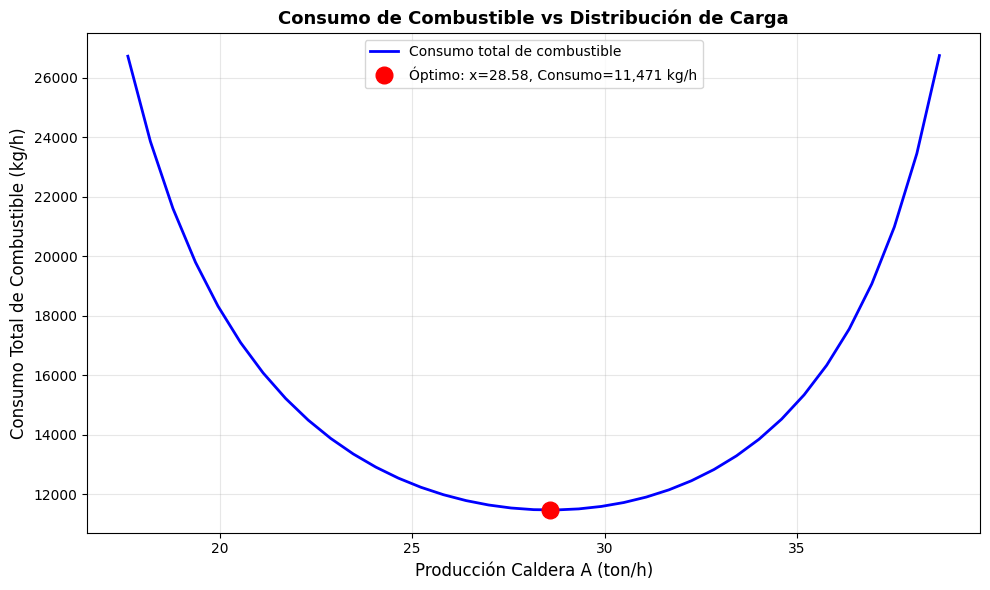

✓ Gráfica de consumo vs distribución generada


In [7]:
if resultados_opt is not None:
    x_grid = np.linspace(X_MIN, X_MAX, 50)
    consumos = []
    x_factibles = []

    for x_val in x_grid:
        y_val = DEMANDA - x_val

        if Y_MIN <= y_val <= Y_MAX:
            eta_A = ETA_A_0 - ETA_A_1 * x_val**2
            eta_B = ETA_B_0 - ETA_B_1 * y_val**2

            if eta_A >= ETA_MIN and eta_B >= ETA_MIN:
                consumo_A = (x_val * 1000 * h) / (eta_A * PCI)
                consumo_B = (y_val * 1000 * h) / (eta_B * PCI)
                consumo_total = consumo_A + consumo_B

                consumos.append(consumo_total)
                x_factibles.append(x_val)

    plt.figure(figsize=(10, 6))
    plt.plot(x_factibles, consumos, 'b-', linewidth=2, label='Consumo total de combustible')
    plt.plot(x_opt, consumo_total_opt, 'ro', markersize=12,
             label=f'Óptimo: x={x_opt:.2f}, Consumo={consumo_total_opt:,.0f} kg/h')
    plt.xlabel('Producción Caldera A (ton/h)', fontsize=12)
    plt.ylabel('Consumo Total de Combustible (kg/h)', fontsize=12)
    plt.title('Consumo de Combustible vs Distribución de Carga', fontsize=13, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    print("✓ Gráfica de consumo vs distribución generada")

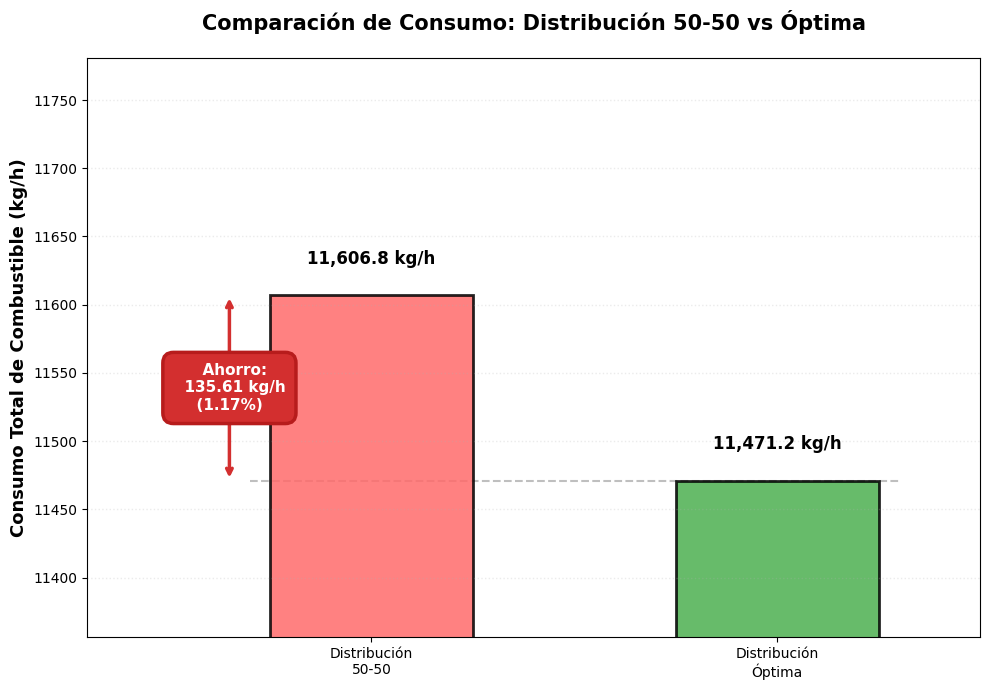

✓ Gráfica de comparación de escenarios generada


In [13]:
# ============================================================================
# CELDA ADICIONAL: Comparación Visual de Escenarios (Versión Limpia)
# ============================================================================
"""
Gráfica de barras comparando el consumo entre distribución 50-50 y óptima
"""

if resultados_opt is not None:
    # Calcular escenario 50-50
    x_50 = 30
    y_50 = 30
    eta_A_50 = ETA_A_0 - ETA_A_1 * x_50**2
    eta_B_50 = ETA_B_0 - ETA_B_1 * y_50**2
    consumo_50_50 = (x_50 * 1000 * h) / (eta_A_50 * PCI) + (y_50 * 1000 * h) / (eta_B_50 * PCI)

    # Crear figura
    fig, ax = plt.subplots(figsize=(10, 7))

    escenarios = ['Distribución\n50-50', 'Distribución\nÓptima']
    consumos_comp = [consumo_50_50, consumo_total_opt]
    colores = ['#FF6B6B', '#4CAF50']  # Rojo y verde más vivos

    bars = ax.bar(escenarios, consumos_comp, color=colores,
                   edgecolor='black', linewidth=2, width=0.5, alpha=0.85)

    ax.set_ylabel('Consumo Total de Combustible (kg/h)',
                   fontsize=13, fontweight='bold')
    ax.set_title('Comparación de Consumo: Distribución 50-50 vs Óptima',
                 fontsize=15, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.25, axis='y', linestyle=':', linewidth=1)

    # Agregar valores sobre las barras
    for i, (bar, consumo) in enumerate(zip(bars, consumos_comp)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 20,
                f'{consumo:,.1f} kg/h',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Calcular ahorro
    ahorro = consumo_50_50 - consumo_total_opt
    ahorro_pct = (ahorro / consumo_50_50) * 100

    # Dibujar líneas punteadas desde las barras
    y_ref_50 = consumo_50_50
    y_ref_opt = consumo_total_opt

    # Línea horizontal en el nivel del óptimo
    ax.hlines(y_ref_opt, -0.3, 1.3, colors='gray', linestyles='--',
              linewidth=1.5, alpha=0.5, zorder=0)

    # Flecha y texto de ahorro ARRIBA a la izquierda
    ax.annotate('',
                xy=(-0.35, y_ref_opt),
                xytext=(-0.35, y_ref_50),
                arrowprops=dict(arrowstyle='<->', color='#D32F2F', lw=2.5))

    # Recuadro de ahorro completamente fuera
    ax.text(-0.35, (y_ref_50 + y_ref_opt)/2,
            f'  Ahorro:\n  {ahorro:.2f} kg/h\n  ({ahorro_pct:.2f}%)  ',
            fontsize=11, color='white', fontweight='bold',
            va='center', ha='center',
            bbox=dict(boxstyle='round,pad=0.7', facecolor='#D32F2F',
                     edgecolor='#B71C1C', linewidth=2.5))

    # Ajustar límites
    ax.set_xlim(-0.7, 1.5)
    ax.set_ylim(min(consumos_comp) * 0.99, max(consumos_comp) * 1.015)

    plt.tight_layout()
    plt.savefig('comparacion_escenarios.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Gráfica de comparación de escenarios generada")

## Celda 9: Tabla Resumen de Resultados

In [8]:
if resultados_opt is not None:
    data_resumen = {
        'Caldera': ['A', 'B', 'Total'],
        'Producción (ton/h)': [x_opt, y_opt, x_opt + y_opt],
        '% de Demanda': [x_opt/DEMANDA*100, y_opt/DEMANDA*100, 100],
        'Eficiencia (%)': [eta_A_opt*100, eta_B_opt*100, None],
        'Consumo Combustible (kg/h)': [consumo_A_opt, consumo_B_opt, consumo_total_opt]
    }

    df_resumen = pd.DataFrame(data_resumen)

    print("\n" + "="*80)
    print("TABLA RESUMEN DE RESULTADOS ÓPTIMOS")
    print("="*80)
    print(df_resumen.to_string(index=False))
    print("="*80)


TABLA RESUMEN DE RESULTADOS ÓPTIMOS
Caldera  Producción (ton/h)  % de Demanda  Eficiencia (%)  Consumo Combustible (kg/h)
      A            28.58221     47.637016       49.152864                 5427.299026
      B            31.41779     52.362984       48.516898                 6043.929398
  Total            60.00000    100.000000             NaN                11471.228424


## Celda 10: Análisis de Ahorro y Conclusiones

In [9]:
if resultados_opt is not None:
    # Calcular consumo con distribución 50-50
    x_50 = 30
    y_50 = 30
    eta_A_50 = ETA_A_0 - ETA_A_1 * x_50**2
    eta_B_50 = ETA_B_0 - ETA_B_1 * y_50**2
    consumo_50_50 = (x_50 * 1000 * h) / (eta_A_50 * PCI) + (y_50 * 1000 * h) / (eta_B_50 * PCI)

    ahorro_absoluto = consumo_50_50 - consumo_total_opt
    ahorro_porcentual = (ahorro_absoluto / consumo_50_50) * 100

    print("\n" + "="*80)
    print("ANÁLISIS DE AHORRO")
    print("="*80)
    print(f"\nEscenario Base (distribución 50-50):")
    print(f"  Consumo total: {consumo_50_50:,.2f} kg/h")

    print(f"\nEscenario Óptimo:")
    print(f"  Consumo total: {consumo_total_opt:,.2f} kg/h")

    print(f"\n{'AHORRO OBTENIDO:':<30} {ahorro_absoluto:>10,.2f} kg/h")
    print(f"{'REDUCCIÓN PORCENTUAL:':<30} {ahorro_porcentual:>10.2f}%")
    print("="*80)

    # Impacto anual
    horas_año = 8400
    costo_combustible = 0.50
    factor_emision = 2.5

    ahorro_anual_kg = ahorro_absoluto * horas_año
    ahorro_economico = ahorro_anual_kg * costo_combustible
    reduccion_co2 = ahorro_anual_kg * factor_emision

    print(f"\n{'IMPACTO ANUAL (8,400 h/año):':^80}")
    print("-"*80)
    print(f"Ahorro de combustible:    {ahorro_anual_kg:>15,.0f} kg/año")
    print(f"Ahorro económico:         ${ahorro_economico:>14,.0f} USD/año")
    print(f"Reducción de CO₂:         {reduccion_co2:>15,.0f} kg/año")
    print("="*80)

    print(f"\n{'CONCLUSIÓN':^80}")
    print("-"*80)
    print(f"La optimización permite reducir el consumo de combustible en")
    print(f"{ahorro_absoluto:,.2f} kg/h ({ahorro_porcentual:.2f}%), representando")
    print(f"un ahorro económico anual de ${ahorro_economico:,.0f} USD y una")
    print(f"reducción de {reduccion_co2/1000:,.1f} toneladas de CO₂ al año.")
    print("="*80)

print("\n✓ Análisis completado exitosamente")


ANÁLISIS DE AHORRO

Escenario Base (distribución 50-50):
  Consumo total: 11,606.84 kg/h

Escenario Óptimo:
  Consumo total: 11,471.23 kg/h

AHORRO OBTENIDO:                   135.61 kg/h
REDUCCIÓN PORCENTUAL:                1.17%

                          IMPACTO ANUAL (8,400 h/año):                          
--------------------------------------------------------------------------------
Ahorro de combustible:          1,139,117 kg/año
Ahorro económico:         $       569,559 USD/año
Reducción de CO₂:               2,847,793 kg/año

                                   CONCLUSIÓN                                   
--------------------------------------------------------------------------------
La optimización permite reducir el consumo de combustible en
135.61 kg/h (1.17%), representando
un ahorro económico anual de $569,559 USD y una
reducción de 2,847.8 toneladas de CO₂ al año.

✓ Análisis completado exitosamente
